## Challenge: A deep dive into Dialogue Act Recognition
**By**: *Ward Van den Bossche*, **Student ID**: *0605083*

**TODO List (after first meeting)**:
- Test multi-label classification algorithms (think about other possibilities)
- ~~On removing punctuation in tokenization: if it relates to emotion recognition -> exclamations could be relevant~~
- Frequency -> if appears too much it might also be redundant (don't provide content) (look into stop word elimination in python)
- <unk> token -> look into other solutions?
- for single utterances: could also try decision trees, support vector based, etc.
- ~~feel free to test your approach with whole dataset (study size vs model performance tradeoff)~~
- consider how to represent the utterance, might influence classification:
    - see in similar papers how they represent utterance
    - take a look at paper: "A Comprehensive Survey of Sentence Representations: From the BERT Epoch to the CHATGPT Era and Beyond"
        see if it's easy to apply (if you find code) how does representation influence the final result
- visualize confusion matrix: true vs predicted classes and see where the classifier makes mistakes


In [1]:
USING_COLAB = False
if USING_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

"The Schema-Guided Dialogue (SGD) dataset consists of over 20k annotated multi-domain, task-oriented conversations between a human and a virtual assistant" (https://github.com/google-research-datasets/dstc8-schema-guided-dialogue) It pertains to different domains like banking and weather. In addition to a training and test set, there is also a crowdfunded variant dataset (SGD-X) that can be used to test a model's generalization capabilities to real-world settings.  What's interesting for this project is the dialogue act annotations, which are defined for both system and user. Some possible values include: INFORM, REQUEST, CONFIRM. A complete list can be found on the dataset's github README.md file.

In [2]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import torch
import pandas as pd
import json
import pickle
import torch.utils.data
from tqdm import tqdm
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np
import re

# Set random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Only need to run this code block once, to get a properly formatted json file for test and train set

# train_path = os.path.join(os.getcwd(), 'SGD Dataset', 'TrainSet.json')
# test_path = os.path.join(os.getcwd(), 'SGD Dataset', 'TestSet.json')

# def format_json(path):
#     # For readability purposes, ensure proper structure in the train/test set files
#     with open(path, "r") as f:
#         data = json.load(f)

#     with open(path.replace(".json", "_formatted.json"), "w") as f:
#         json.dump(data, f, indent=4, ensure_ascii=False)

# format_json(train_path)
# format_json(test_path)

In [4]:
if USING_COLAB:
  path_to_dataset = os.path.join(os.getcwd(), "drive", "MyDrive", "Current Trends VUB", 'SGD Dataset')
else:
  path_to_dataset = os.path.join(os.getcwd(), 'SGD Dataset')
path_to_train = os.path.join(path_to_dataset, "TrainSet.json")
path_to_test = os.path.join(path_to_dataset, "TestSet.json")

### Implementation 1: Simple RNN

For the first implementation we'll train a simple RNN and LSTM on the utterances of this dataset, note that this is an utterance level model, trained on a (small) subset of the whole dataset. (TODO: might be interesting to compare with the whole dataset). At inference time the user can then input an utterance and have the system return a dialogue act predicted by the neural network. The code is based on WPOs from the course "Deep Learning" of the master applied computer science at VUB, where it was used in a toy dataset for sentiment analysis and could serve as a benchmark to compare our future models with.

#### Preprocessing
The preprocessing step involves extracting all utterances from the.json files, together with their dialogue acts, which will be used as "labels" in our prediction task. In addition to this, the speaker can be USER or SYSTEM, this information will be encoded in a separate token.

In [5]:
EOD = "<eod>" # End of dialogue token

In [6]:
def extract_turn_data(file_path):
    all_data = []
    with open(file_path, 'r') as f:
        data = json.load(f)
        for dialogue in data:
            for turn in dialogue['turns']:
                all_data.append({
                    'speaker': turn['speaker'],
                    'utterance': turn['utterance'],
                    'act': turn["dialogue_act"]
                })
            all_data[-1]['utterance'] += f" {EOD}" # Add an End Of Dialogue marker at the end of last utterance in turn
    return all_data

extracted_train = extract_turn_data(path_to_train)
extracted_test = extract_turn_data(path_to_test)

for i in range(22, 25):
    print(extracted_train[i])

{'speaker': 'USER', 'utterance': 'I appreciate it very much. That would be all.', 'act': 'USER_THANK_YOU|USER_GOODBYE'}
{'speaker': 'SYSTEM', 'utterance': 'Have a good time! <eod>', 'act': 'SYSTEM_GOODBYE'}
{'speaker': 'USER', 'utterance': 'Hi i need a help, i am very hungry, I am looking for a restaurant', 'act': 'USER_INFORM_INTENT'}


In [7]:
acts = list(set([data['act'] for data in extracted_train] + [data['act'] for data in extracted_test]))

acts_labels = {act : i for i, act in enumerate(acts)}
inv_acts_labels = {v: k for k, v in acts_labels.items()}

# Modified code for processing turns
label_train = [ acts_labels[turn['act']] for turn in extracted_train ]
label_test = [ acts_labels[turn['act']] for turn in extracted_test ]

In [8]:
print(acts_labels, label_train[:5])

{'USER_INFORM_INTENT|USER_THANK_YOU': 0, 'SYSTEM_INFORM': 1, 'USER_NEGATE': 2, 'USER_AFFIRM_INTENT': 3, 'USER_INFORM|USER_NEGATE': 4, 'SYSTEM_REQ_MORE': 5, 'USER_INFORM': 6, 'USER_INFORM_INTENT|USER_SELECT': 7, 'USER_NEGATE|USER_GOODBYE': 8, 'SYSTEM_OFFER': 9, 'USER_INFORM|USER_INFORM_INTENT|USER_NEGATE_INTENT': 10, 'USER_INFORM|USER_INFORM_INTENT': 11, 'SYSTEM_OFFER|SYSTEM_INFORM_COUNT': 12, 'SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS': 13, 'USER_THANK_YOU|USER_GOODBYE': 14, 'SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE': 15, 'USER_INFORM|USER_REQUEST_ALTS': 16, 'USER_NEGATE_INTENT|USER_GOODBYE': 17, 'SYSTEM_CONFIRM': 18, 'USER_INFORM_INTENT|USER_NEGATE_INTENT': 19, 'USER_REQUEST': 20, 'USER_REQUEST_ALTS': 21, 'USER_NEGATE_INTENT': 22, 'SYSTEM_NOTIFY_SUCCESS': 23, 'USER_THANK_YOU': 24, 'SYSTEM_OFFER_INTENT': 25, 'USER_INFORM|USER_INFORM_INTENT|USER_SELECT': 26, 'USER_INFORM|USER_INFORM_INTENT|USER_THANK_YOU': 27, 'SYSTEM_REQUEST': 28, 'SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE': 29, 'SYSTEM_GOO

In [9]:
def clean_utterances(extracted_turns):
    speakers = []
    utterances = []
    
    for data in extracted_turns:
        utterance = data['utterance'].lower()

        # Replace monetary values: "$23.53", "$1,000", "$500"
        utterance = re.sub(r'\$\d+(?:,\d{3})*(?:\.\d{2})?', '<price>', utterance)

        # Replace all remaining numbers with <number>
        utterance = re.sub(r'\b\d+\b', '<number>', utterance)

        # Separate "?" from words (turns "hello?" into "hello ?")
        # such that it can become it's own token and maybe help the model recognize "requests"
        utterance = re.sub(r'(\w+)\?', r'\1 ?', utterance)

        # Remove unwanted characters
        chars_to_erase = ['.', ',', '!', '$']
        for char in chars_to_erase:
            utterance = utterance.replace(char, '')

        utterances.append(utterance)
        speakers.append(data['speaker'])
    
    return speakers, utterances


In [10]:
speakers_train, utterances_train = clean_utterances(extracted_train)
speakers_test, utterances_test = clean_utterances(extracted_test)

In [11]:
print(len(speakers_train), len(utterances_train), len(label_train))
print(len(speakers_test), len(utterances_test), len(label_test))
print(list(set(speakers_train)))
# Sanity check
assert len(speakers_train) == len(utterances_train) == len(label_train), "Lengths of speakers, utterances and labels do not match"
assert list(set(speakers_train)) == ['USER', 'SYSTEM'] # Confirm that user and system are the only speakers

82588 82588 82588
16850 16850 16850
['USER', 'SYSTEM']


In [12]:
word_freq = Counter()
for utterance in utterances_train:
    utterance_words = utterance.split()
    word_freq.update(utterance_words)

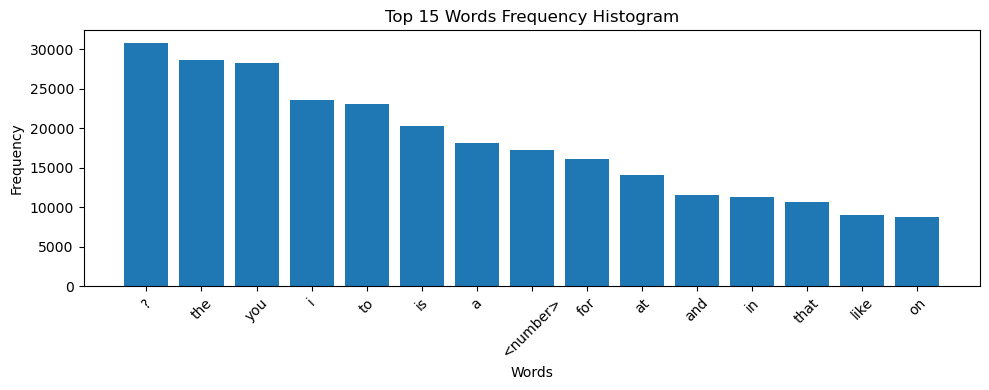

In [13]:
# lets have a look at the top 10 words
top_words = [word for word, count in word_freq.most_common(15)]
top_frequencies = [count for word, count in word_freq.most_common(15)]

# Create a bar plot for the top 5 words
plt.figure(figsize=(10,4))
plt.bar(top_words, top_frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Words Frequency Histogram")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [14]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['USER'] = len(word_map) + 1
word_map['SYSTEM'] = len(word_map) + 1
word_map['<pad>'] = 0
rev_word_map = {v: k for k, v in word_map.items()}

print(f"Total words are: {len(word_map)}")

Total words are: 2706


In [15]:
def encode_text(utterances, speakers, max_len):
    """
    Assign a numerical value (0 to len(word_map)) to each word in the
    utterance while handling special tokens.
    """
    encoded_texts = []
    
    for i in range(len(utterances)):
        utterance = utterances[i]
        speaker = speakers[i]
        utterance_words = utterance.lower().split()
        is_last_utterance = utterance_words[-1] == EOD.lower()
        adjusted_max_len = max_len - (3 if is_last_utterance else 2)  # Adjust for special tokens
        words = utterance_words[:adjusted_max_len]

        # Tokenization with special tokens
        tokenized = [word_map['<start>']]
        tokenized += [word_map[speaker]]
        tokenized += [word_map.get(word, word_map['<unk>']) for word in words]
        tokenized.append(word_map['<end>'])
        
        if is_last_utterance:
            tokenized.append(word_map[EOD])
        
        # Padding
        tokenized += [word_map['<pad>']] * (adjusted_max_len - len(words))
        
        encoded_texts.append(tokenized)
    
    return encoded_texts


In [16]:
encoded_texts = encode_text(utterances_train, speakers_train, max_len = 100)
encoded_texts_test = encode_text(utterances_test, speakers_train, max_len = 100)

In [17]:
# test one sample
example_tokens = encoded_texts[23]
print(" ".join([rev_word_map[t] for t in example_tokens]))
print(len(example_tokens))

<start> SYSTEM have a good time <eod> <end> <eod> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
101


#### Dataset and Data Loaders

In [18]:
X_train = torch.tensor(encoded_texts)    # (number_of_samples, max_length)
y_train = torch.LongTensor(label_train)  # (number_of_samples)
X_test = torch.tensor(encoded_texts_test)
y_test = torch.LongTensor(label_test)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=128, 
                                          shuffle=True)

#### Architectures

RNN Network defined by:

$h_t= \tanh \left(W_h \cdot\left[h_{t-1}, x_t\right]+b_i\right)$ <br>

In [19]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super(RNN, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        self.W_h = nn.Linear(input_sz + hidden_sz, hidden_sz)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()

        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device),
                    torch.zeros(batch_size, self.hidden_size).to(device))

        hidden_states = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            common_input = torch.cat([x_t, h_t], dim=-1)
            h_t = torch.tanh(self.W_h(common_input))
            hidden_states.append(h_t.unsqueeze(1))

        hidden_states = torch.cat(hidden_states, dim=1)

        return hidden_states

In [20]:
class LSTM(nn.Module):
    
    def __init__(self, input_sz, hidden_sz):
        
        super(LSTM, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #c_t: new memory (the new memory)
        self.W_c = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #i_t: input gate (how much to take from the new memory)
        self.W_i = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #f_t: forget gate (how much to forget from the old memory)
        self.W_f = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #o_t: output gate (how much to take from the new memory to represent the output)
        self.W_o = nn.Linear(input_sz + hidden_sz, hidden_sz)

        self.init_weights()
        
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()  
        
        # initialize h_t and c_t to zeros
        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device), 
                    torch.zeros(batch_size,self.hidden_size).to(device))
        
        hidden_states = []
        
        for t in range(seq_len):
            # get the input at the current timestep 
            x_t = x[:, t, :]
            
            # run the LSTM Cell
            common_input = torch.cat([x_t, h_t], dim = -1)
            
            new_c = torch.tanh(self.W_c(common_input))
            i_t = torch.sigmoid(self.W_i(common_input))
            f_t = torch.sigmoid(self.W_f(common_input))
            c_t = f_t * c_t + i_t * new_c
            
            o_t = torch.sigmoid(self.W_o(common_input))
            h_t = o_t * torch.tanh(c_t)
            
            # save the hidden states in a list
            hidden_states.append(h_t.unsqueeze(1))
            
        hidden_states = torch.cat(hidden_states, dim = 1)
            
        return hidden_states

In [21]:
class Net(nn.Module):
    
    def __init__(self, input_embedding_size, hidden_size, pooling_type = 'last_hidden_state'):
        
        super().__init__()

        self.embedding = nn.Embedding(len(word_map), input_embedding_size)
        # self.rnn = RNN(input_embedding_size, hidden_size) # Uncomment for RNN (and change in forward pass)
        self.lstm = LSTM(input_embedding_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, len(acts_labels))
        self.pooling_type = pooling_type
        
    def forward(self, x):
        
        # x is of shape (batch_size, max_seq_length)
        x = self.embedding(x)   # (batch_size, seq_len, embed_dim)
        x = self.lstm(x)        # (batch_size, seq_len, hidden_size)

        if self.pooling_type == "last_hidden_state":
            x = x[:, -1, :]     # (batch_size, hidden_size)
        else:
            x = x.mean(1)       # (batch_size, hidden_size)

        x = self.classifier(x)         # (batch_size, len(acts_labels))
        return x

#### Training

In [22]:
def train(model, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # move to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # run forward-backward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = train_loss / (batch_idx+1)
    epoch_acc = 100.* correct / total
    print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, epochs, batch_idx, 
                                                                                       len(train_loader),
                                                                                       epoch_loss, 
                                                                                       epoch_acc))
    return epoch_loss, epoch_acc

In [23]:
model = Net(input_embedding_size = 256, hidden_size = 512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
epochs = 10

losses = []
accuracies = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(model, optimizer, criterion, epoch)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

Epoch 0/10, Iter 645/646, Train Loss: 3.199, Train Accuracy: 10.342
Epoch 1/10, Iter 645/646, Train Loss: 3.190, Train Accuracy: 10.468
Epoch 2/10, Iter 645/646, Train Loss: 3.190, Train Accuracy: 10.425
Epoch 3/10, Iter 645/646, Train Loss: 3.190, Train Accuracy: 10.360
Epoch 4/10, Iter 645/646, Train Loss: 3.188, Train Accuracy: 10.429
Epoch 5/10, Iter 645/646, Train Loss: 3.187, Train Accuracy: 10.394
Epoch 6/10, Iter 645/646, Train Loss: 3.188, Train Accuracy: 10.393
Epoch 7/10, Iter 645/646, Train Loss: 3.188, Train Accuracy: 10.373
Epoch 8/10, Iter 645/646, Train Loss: 3.188, Train Accuracy: 10.338
Epoch 9/10, Iter 645/646, Train Loss: 3.188, Train Accuracy: 10.453


Text(0.5, 1.0, 'Loss Curve')

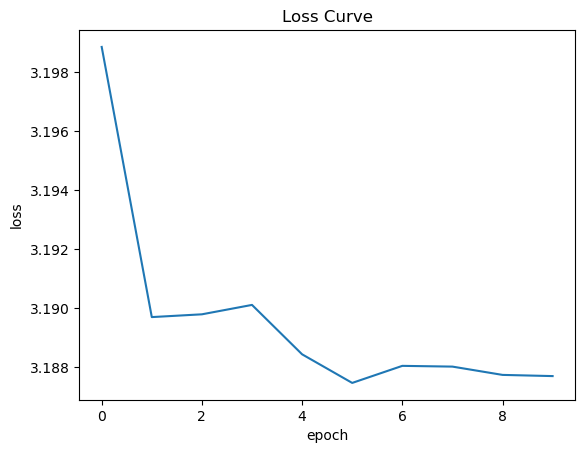

In [24]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Curve')

Text(0.5, 1.0, 'Accuracy Curve')

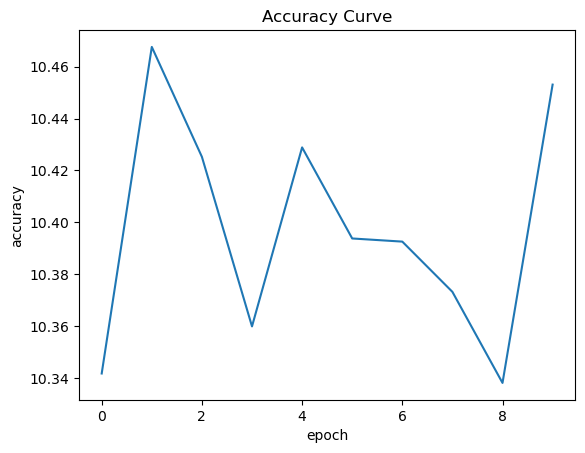

In [25]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Curve')

In [26]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

acc = 100.*correct/total
print('Test Accuracy: {:.3f}'.format(acc))
top5_acc = 0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.topk(5, 1, True, True)
        total += targets.size(0)
        correct += torch.sum(predicted.eq(targets.view(-1, 1)))
top5_acc = 100.*correct/total
print('Top 5 Test Accuracy: {:.3f}'.format(top5_acc))

100%|██████████| 132/132 [00:05<00:00, 25.39it/s]


Test Accuracy: 11.638


100%|██████████| 132/132 [00:05<00:00, 25.94it/s]

Top 5 Test Accuracy: 27.101


In [34]:
def predict_input(model, text, speaker=None, is_text_encoded=False):

    print("-------------------")
    if not is_text_encoded:
        _, cleaned_text = clean_utterances([{'utterance': text, 'speaker': speaker}])
        encoded_test_sentence = encode_text(cleaned_text, [speaker], max_len = 100)
        print(' '.join([rev_word_map[w] for w in encoded_test_sentence[0]]))
    elif (speaker is None):
        sentence = ' '.join([rev_word_map[w] for w in text.tolist()])
        print(sentence)
        encoded_test_sentence = text.unsqueeze(0)
    else:
        # throw error (because either speaker is None and text_encoded is True or speaker is filled in and text_encoded is False)
        raise ValueError("If text is encoded: don't provide speaker, if text is not encoded: provide speaker")
    
    model.eval()
    with torch.no_grad():
        output = model(torch.tensor(encoded_test_sentence).to(device))
        prob, pred = F.softmax(output, dim = -1).max(1)
    print('index {} ({}) is predicted with a probability of {}'.format(pred.item(), inv_acts_labels[pred.item()], prob.item()))
    print('True label is {}'.format(inv_acts_labels[targets[5].item()]))

    all_probs = F.softmax(output, dim = -1)

    predictions_with_probs = [(inv_acts_labels[i], p.item()) for i, p in enumerate(all_probs[0])]
    # for pred, prob in predictions_with_probs:
    #     print(f"{pred}: {prob:.3f}")

    
    # Top 5 predictions and top 5 accuracy
    top_5_preds = all_probs.topk(5)
    top_5_preds_indices = top_5_preds.indices[0]
    top_5_preds_probs = top_5_preds.values[0]
    top_5_preds_with_probs = [(inv_acts_labels[i.item()], p.item()) for i, p in zip(top_5_preds_indices, top_5_preds_probs)]

    print("Top 5 predictions with probabilities:")
    for pred, prob in top_5_preds_with_probs:
        print(f"{pred}: {prob:.3f}")
        
    return output, prob, pred

In [ ]:
sample = inputs[3]
output, prob, pred = predict_input(model, text=sample, is_text_encoded=True)

-------------------
<start> SYSTEM sure i found <number> in the petaluma area do you want to give <unk> <unk> peter t a try ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


C:\Users\Ward\AppData\Local\Temp\ipykernel_30624\1163406323.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(encoded_test_sentence).to(device))


index 6 (USER_INFORM) is predicted with a probability of 0.1128297820687294
True label is USER_REQUEST
Top 5 predictions with probabilities:
USER_INFORM: 0.113
SYSTEM_REQUEST: 0.106
SYSTEM_GOODBYE: 0.062
SYSTEM_OFFER: 0.060
SYSTEM_CONFIRM: 0.057


In [ ]:
test_sentence = "Goodbye!"
_ = predict_input(model, text=test_sentence, speaker="USER")

-------------------
<start> USER goodbye <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
index 6 (USER_INFORM) is predicted with a probability of 0.1128297820687294
True label is USER_REQUEST
Top 5 predictions with probabilities:
USER_INFORM: 0.113
SYSTEM_REQUEST: 0.106
SYSTEM_GOODBYE: 0.062
SYSTEM_OFFER: 0.060
SYSTEM_CONFIRM: 0.057


### Implementation 2: Paper - "A Context-based Approach for Dialogue Act Recognition using Simple Recurrent Neural Networks"